# Установка библиотек

In [1]:
!pip install hazardous@git+https://github.com/soda-inria/hazardous
!pip install pycox
!pip install scikit-survival
!pip install numba --user

  Cloning https://github.com/soda-inria/hazardous to c:\users\pridanova\appdata\local\temp\4\pip-install-rfqk3_ea\hazardous_eebeba0e66c94d46b68a7edc99ecd0be
  Resolved https://github.com/soda-inria/hazardous to commit f75d272d542e20298b5a33545e6717b4bd03c35d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: still running...
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
  Rolling back uninstall of pandas
  Moving to c:\users

  Running command git clone -q https://github.com/soda-inria/hazardous 'C:\Users\pridanova\AppData\Local\Temp\4\pip-install-rfqk3_ea\hazardous_eebeba0e66c94d46b68a7edc99ecd0be'
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\ProgramData\\Anaconda3\\envs\\survive\\Lib\\site-packages\\pandas\\conftest.py'
Consider using the `--user` option or check the permissions.



In [2]:
from datetime import datetime
from hazardous import SurvivalBoost
from hazardous.metrics import integrated_brier_score_survival, integrated_brier_score_incidence
from lifelines import AalenJohansenFitter
from lifelines.utils import concordance_index
from pycox.evaluation import EvalSurv
from pycox.models import DeepHit
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sksurv.metrics import check_y_survival, CensoringDistributionEstimator
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv
from typing import List
from zipfile import ZipFile
import io
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import os
import pandas as pd
import pandas as pd
import re
import seaborn as sns
import torch
import torchtuples as tt
import warnings

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Подготовка данных

In [3]:
warnings.filterwarnings('ignore')

In [4]:
ibs = {}

In [19]:
dtypes = {'credit_score': 'Int16', 'first_payment_date': 'str', 'first_time_homebuyer_flag': 'str',
        'maturity_date': 'str', 'MSA': 'Int32', 'MI_%': 'Int16', 'units_numb': 'Int8', 'occupancy_status': 'str',
        'CLTV': 'Int16', 'DTI_ratio': 'Int16', 'orig_UPB': 'Int64', 'LTV': 'Int16', 'orig_interest_rate': 'str',
        'channel': 'str', 'PPM_flag': 'str', 'amortization_type': 'str',
        'property_state': 'str', 'property_type': 'str', 'postal_code': 'Int32', 'id_loan': 'str',
        'loan_purpose': 'str', 'orig_loan_term': 'Int16', 'borrowers_num': 'Int8', 'seller_name': 'str',
        'service_name': 'str', 'super_conf_flag': 'str', 'id_loan_preharp': 'str',
        'program_ind': 'str', 'HARP_ind': 'str', 'property_val_method': 'Int64',
        'int_only_flag': 'str', 'MI_cancel_flag': 'str', 'orig_interest_rate':'float32'}

static = ['credit_score', 'first_time_homebuyer_flag', 'units_numb', 'MSA', 'MI_%', 'occupancy_status', 'CLTV', 'DTI_ratio', 'orig_UPB',
       'LTV', 'orig_interest_rate', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'zero_balance_code', 'property_type', 'loan_purpose', 'orig_loan_term', 'borrowers_num', 'super_conf_flag',
       'int_only_flag', 'property_val_method']

categ = ['occupancy_status', 'first_time_homebuyer_flag', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'borrowers_num', 'int_only_flag', 'property_val_method', 'modification_flag', 'step_mod_flag', 'deferred_payment_plan',
         'ELTV', 'delinq_due_disaster', 'borrowe_asistance_stat_code', 'property_type', 'loan_purpose', 'super_conf_flag']

def get_y(cens, time):
    cens, time = np.array(cens), np.array(time)
    y = np.empty(dtype=[('event', int), ('duration', np.float64)], shape=cens.shape[0])
    y['event'] = cens
    y['duration'] = time
    return y


def get_y_event(y_, events: List=[]):
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=y_.shape[0])
    y['event'] = y_.event.isin(events)
    y['duration'] = y_.duration
    return y

def convert(curves, time, y):
    grid = np.linspace(y.min(), y.max(), 100)
    idx = np.searchsorted(grid, time[::-1])
    if len(curves.shape)==1:
      new = np.full(100, None)
      new[idx[::-1]] = curves
      return pd.DataFrame(new).replace(to_replace=None, method='ffill').values, grid
    elif len(curves.shape)==2:
      idx = idx[::-1]
      new = np.full((curves.shape[0], 100), None)
      row = np.repeat(np.arange(new.shape[0]), idx.shape[0])
      col = np.tile(idx, new.shape[0])
      new[row, col] = curves.ravel()
      return pd.DataFrame(new.T).replace(to_replace=None, method='ffill').values.T, grid

    else:
      return None


def str_to_categ(df_col):
    uniq = df_col.unique()
    return df_col.map(dict(zip(uniq, range(len(uniq)))))


def calc_short():
    file = r"D:\SurvivalAnalysis\CompetingRisk\files\result_short.csv"
    df = pd.read_csv(file, dtype=dtypes)
    df['event'] = df.zero_balance_code.astype('int')*(df.cens.astype('int'))
    df = df[static+['time', 'event']]
    df = df.apply(lambda x: str_to_categ(x) if x.name in categ else x, axis=0)
    sign = sorted(list(set(df.columns) - {'time', 'event'}))
    y = get_y(df['event'], df['time'] + 1)
    X = df.loc[:, sign]
    return y, X, sign, categ, df

In [6]:
y, X, sign, categ, df = calc_short()
df

,credit_score,first_time_homebuyer_flag,units_numb,MSA,MI_%,occupancy_status,CLTV,DTI_ratio,orig_UPB,LTV,...,zero_balance_code,property_type,loan_purpose,orig_loan_term,borrowers_num,super_conf_flag,int_only_flag,property_val_method,time,event
0,750,0,1,31540,0,0,74,32,101000,74,...,1.0,0,0,337,0,0,0,0,8,1
1,762,0,1,29100,0,0,54,27,112000,54,...,1.0,0,1,336,1,0,0,0,7,1
2,750,0,1,<NA>,0,0,49,21,188000,49,...,1.0,0,1,336,0,0,0,0,7,1
3,764,0,1,<NA>,0,0,62,44,149000,62,...,1.0,0,2,340,0,0,0,0,25,1
4,749,0,1,15940,30,0,93,41,84000,93,...,1.0,0,1,333,1,0,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,770,0,1,35614,0,0,62,65,155000,62,...,15.0,0,2,240,1,0,0,0,223,15
23996,682,0,1,39100,35,0,97,47,162000,97,...,15.0,0,1,360,1,0,0,0,223,15
23997,784,0,1,<NA>,0,0,71,45,161000,71,...,15.0,0,2,360,0,0,0,0,138,15
23998,738,0,1,15804,0,0,95,43,282000,80,...,15.0,0,1,360,1,0,0,0,213,15


In [7]:
y_ = pd.DataFrame(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_, test_size=0.2, stratify=y_.event, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train.event, random_state = 1)

<Axes: xlabel='duration', ylabel='Density'>

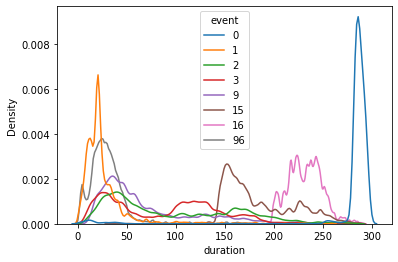

In [8]:
sns.kdeplot(data=y_train, x="duration", hue="event", bw_adjust=0.25, palette="tab10")

# Модели

##AalenJohansenFitter (lifelines)



In [21]:
#aj = AalenJohansenFitter()
#aj.fit(T, E, event_of_interest=1)
curve = 1-aj.cumulative_density_[f'CIF_{1}']
curve_ibs = np.tile(curve, y_test.shape[0]).reshape((curve.shape[0], y_test.shape[0]))
new_curve, grid = convert(curve, aj.cumulative_density_.index, y_train['duration'].values)
new_curve.shape

(100, 1)

ibs:        old time_grid      new time_grid
ibs 1 :         0.23               0.22    
ibs 9 :         0.22               0.20    
ibs 96:         0.23               0.22    
ibs 16:         0.12               0.10    
ibs 3 :         0.21               0.19    
ibs 2 :         0.21               0.19    
ibs 15:         0.16               0.14    


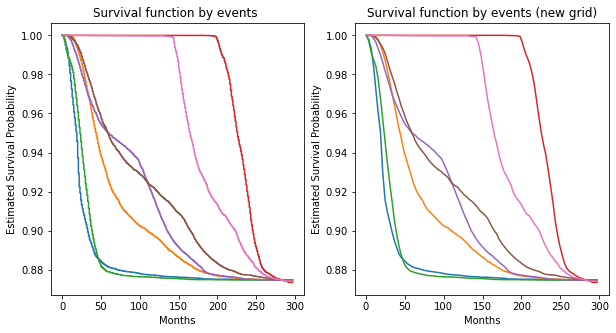

In [22]:
aj = AalenJohansenFitter()
T, E = y_.duration, y_.event
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
scores=[]
print(f"ibs:        old time_grid      new time_grid")
for i in df.event.unique():
  if i:
    aj.fit(T, E, event_of_interest=i)
    curve = 1-aj.cumulative_density_[f'CIF_{i}']
    curve_ibs = np.tile(curve, y_test.shape[0]).reshape((curve.shape[0], y_test.shape[0]))

    new_curve, grid = convert(curve, aj.cumulative_density_.index, y_train['duration'].values)
    new_curve_ibs = np.tile(new_curve, y_test.shape[0]).reshape(new_curve.shape[0], y_test.shape[0])

  # ibs of model with old time_grid

    ibs_1 = ibs_remain(get_y_event(y_train, [i]),
                      get_y_event(y_test, [i]),
                      curve_ibs.T, # curve_ibs
                      times=aj.cumulative_density_.index, axis=-1)

  # ibs of model with new time_grid

    ibs_2 = ibs_remain(get_y_event(y_train, [i]),
                      get_y_event(y_test, [i]),
                      new_curve_ibs.T, # new_curve_ibs
                      times=grid, axis=-1)

    print(f"ibs {i:<2}:         {ibs_1:<4.2f}               {ibs_2:<8.2f}")
    
    axs[1].plot(grid,
                new_curve,
                label=f"event {i}")
    axs[0].plot(aj.cumulative_density_.index,
                curve,
                label=f"event {i}")
for i in (0, 1):
  axs[i].set_title(f"Survival function by events {i*'(new grid)'}")
  axs[i].set_xlabel("Months")
  axs[i].set_ylabel("Estimated Survival Probability")
plt.show()

## SurvivalBoost (hazardous)

In [10]:
survival_boost = SurvivalBoost(show_progressbar=True).fit(x_train, y_train)

100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


In [11]:
x_ = x_test.copy()
x_.MSA.fillna(0, inplace=True)

In [16]:
y_train['duration'].values

array([220.,  45.,  24., ...,  17.,  49., 117.])

        old time_grid      new time_grid
ibs 1 :   0.06                 0.06    
ibs 9 :   0.07                 0.06    
ibs 96:   0.06                 0.06    
ibs 16:   0.08                 0.08    
ibs 3 :   0.07                 0.07    
ibs 2 :   0.08                 0.07    
ibs 15:   0.08                 0.08    
---------
 ibs: 0.06


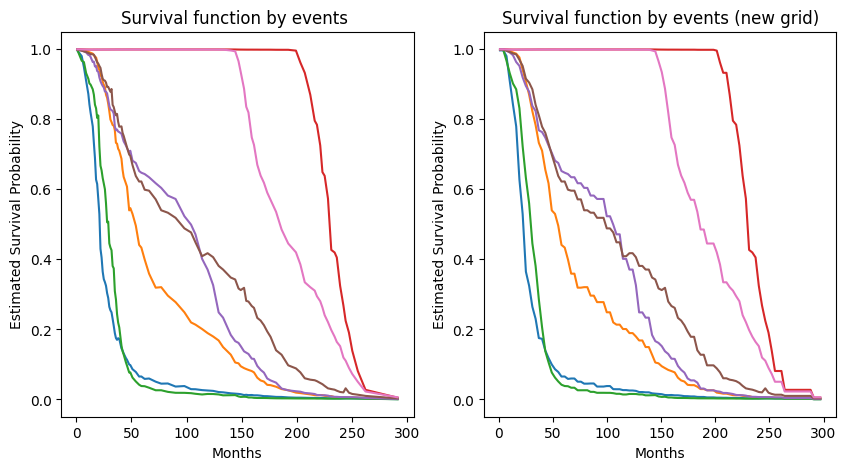

In [20]:
#curves = survival_boost.predict_survival_function(x_)
curves_new, grid = convert(curves, survival_boost.time_grid_, y_train['duration'].values)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
scores=[]
print('        old time_grid      new time_grid')
for ev in df.event.unique():
  if ev:
    mask = y_test["event"] == ev
    mean_survival = curves[mask].mean(axis=0)
    sf, _ = convert(mean_survival, survival_boost.time_grid_, y_train['duration'].values)

    ibs_1 = ibs_remain(get_y_event(y_train, [ev]),
                       get_y_event(y_test, [ev]), curves,
                       times=survival_boost.time_grid_, axis=-1)

    ibs_2 = ibs_remain(get_y_event(y_train, [ev]),
                       get_y_event(y_test, [ev]), curves_new,
                       times=grid, axis=-1)
    print(f"ibs {ev:<2}:   {ibs_1:<4.2f}                 {ibs_2:<8.2f}")

    #scores.append(ibs_)
    #print(f"ibs {ev}: {ibs_}")
    axs[0].plot(
        survival_boost.time_grid_,
        mean_survival,
        label=(f"event {ev}"),
    )

    axs[1].plot(grid, sf, label=(f"event {ev}"))
ibs_ = ibs_remain(get_y_event(y_train, sorted(df.event.unique())[1:]),
                  get_y_event(y_test, sorted(df.event.unique())[1:]), curves, times=survival_boost.time_grid_, axis=-1)
scores.append(ibs_)
print('---------\n', f"ibs: {ibs_:.2f}")
ibs['SurvivalBoost']=scores
for i in (0, 1):
  axs[i].set_title(f"Survival function by events {i*'(new grid)'}")
  axs[i].set_xlabel("Months")
  axs[i].set_ylabel("Estimated Survival Probability")

plt.show()

## DeepHit (pycox)

In [21]:
get_x = lambda df: (df.values.astype('float32'))
get_target = lambda df: (df['duration'].values, df['event'].values)


class LabTransform(LabTransDiscreteTime):
    def transform(self, durations, events):
        durations, is_event = super().transform(durations, events > 0)
        events[is_event == 0] = 0
        return durations, events.astype('int64')


class CauseSpecificNet(torch.nn.Module):
    """Network structure similar to the DeepHit paper, but without the residual
    connections (for simplicity).
    """
    def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                 out_features, batch_norm=True, dropout=None):
        super().__init__()
        self.shared_net = tt.practical.MLPVanilla(
            in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
            batch_norm, dropout,
        )
        self.risk_nets = torch.nn.ModuleList()
        for _ in range(num_risks):
            net = tt.practical.MLPVanilla(
                num_nodes_shared[-1], num_nodes_indiv, out_features,
                batch_norm, dropout,
            )
            self.risk_nets.append(net)

    def forward(self, input):
        out = self.shared_net(input)
        out = [net(out) for net in self.risk_nets]
        out = torch.stack(out, dim=1)
        return out

In [22]:
x_val.MSA.fillna(0, inplace=True)
x_test.MSA.fillna(0, inplace=True)
x_train.MSA.fillna(0, inplace=True)


labtrans = LabTransform(100)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_ = labtrans.fit_transform(*get_target(y_train.sort_values(by='duration')))
y_val = labtrans.transform(*get_target(y_val))
durations_test, events_test = get_target(y_test)
x_train = get_x(x_train)
x_val = get_x(x_val)
x_test = get_x(x_test)
val = (x_val, y_val)
train = (x_train, y_train_)

in_features = x_train.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = y_train_[1].max()
out_features = len(labtrans.cuts)
batch_norm = True
dropout = 0.1

# net = SimpleMLP(in_features, num_nodes_shared, num_risks, out_features)
net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)
optimizer = tt.optim.AdamWR(lr=0.01, decoupled_weight_decay=0.01,
                            cycle_eta_multiplier=0.8)
model = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
                duration_index=labtrans.cuts)

In [23]:
epochs = 512
batch_size = 256
callbacks = [tt.callbacks.EarlyStoppingCycle()]
verbose = True
#x_train_ = x_train_.astype('int64')
log = model.fit(x_train, y_train_, batch_size, epochs, callbacks, verbose, val_data=val)

0:	[11s / 11s],		train_loss: 1.8924,	val_loss: 1.7680
1:	[10s / 21s],		train_loss: 1.5103,	val_loss: 1.4530
2:	[11s / 33s],		train_loss: 1.4301,	val_loss: 1.4489
3:	[18s / 52s],		train_loss: 1.4340,	val_loss: 1.4447
4:	[10s / 1m:2s],		train_loss: 1.4216,	val_loss: 1.4442
5:	[10s / 1m:12s],		train_loss: 1.4156,	val_loss: 1.4483
6:	[14s / 1m:27s],		train_loss: 1.4104,	val_loss: 1.4408
7:	[10s / 1m:37s],		train_loss: 1.4188,	val_loss: 1.4430
8:	[10s / 1m:47s],		train_loss: 1.4246,	val_loss: 1.4855
9:	[10s / 1m:58s],		train_loss: 1.4152,	val_loss: 1.4418
10:	[10s / 2m:8s],		train_loss: 1.4100,	val_loss: 1.4428
11:	[9s / 2m:18s],		train_loss: 1.4083,	val_loss: 1.4422
12:	[10s / 2m:28s],		train_loss: 1.4054,	val_loss: 1.4416
13:	[10s / 2m:39s],		train_loss: 1.4040,	val_loss: 1.4417
14:	[10s / 2m:49s],		train_loss: 1.4019,	val_loss: 1.4425
15:	[10s / 2m:59s],		train_loss: 1.4117,	val_loss: 1.4444


In [24]:
cif = model.predict_cif(x_test)

cif - трехмерный массив размера (96, 100, 4800), где

*   axis=0 - тип события, от 0 до 95 (используется только 8, zero_code -1 соотв.)
*   axis=1 - временная шкала
*   axis=2 - соответствующие наблюдения



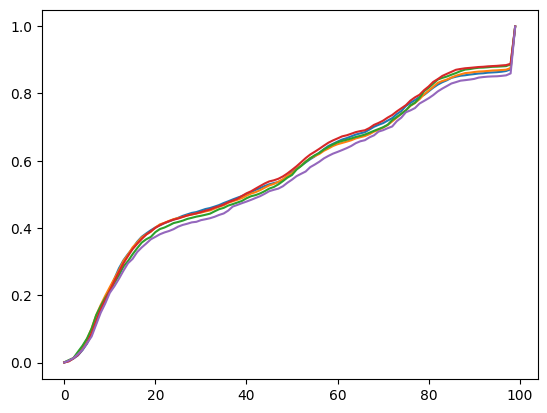

In [ ]:
plt.plot(cif.sum(axis=0)[:, :5])

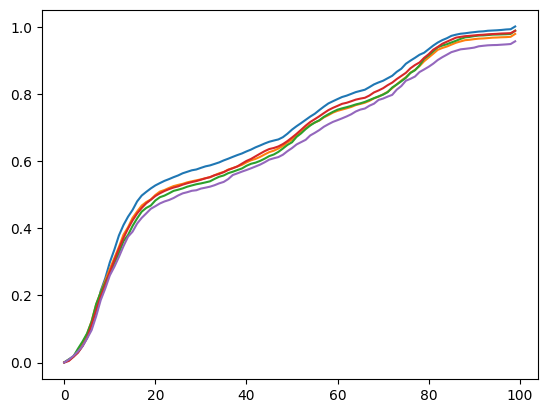

In [ ]:
plt.plot((cif[df.event.unique()-1].sum(axis=0))[:, :5])

In [25]:
def surv_func_1(cif, event_of_interest=1):
  return 1-(cif.transpose()[..., event_of_interest-1])

def surv_func_2(cif, event_of_interest=1):
  return 1 - (cif[df.event.unique()-1].sum(axis=0).T - (cif.transpose()[..., event_of_interest-1]))

def surv_func_3(cif, event_of_interest=1):
  return 1 - (cif.sum(axis=0).T - (cif.transpose()[..., event_of_interest-1]))

1. sf 1:  $$ S_k(t) = 1 - cif_k$$
1. sf 2:  $$ S_k(t) = 1 - \sum_{i!=k} cif_k, i\in (1, 2, 3, 9, 15, 16, 96)$$
1. sf 3:  $$ S_k(t) = 1 - \sum_{i=0, i!=k}^{95} cif_k$$

        1-cif_k      1-summ(cif_i)   1-summ(cif_i) {i=0..95}
ibs 1 :   0.23         0.27                   0.21    
ibs 9 :   0.20         0.27                   0.21    
ibs 96:   0.22         0.26                   0.21    
ibs 16:   0.10         0.37                   0.27    
ibs 3 :   0.19         0.27                   0.21    
ibs 2 :   0.19         0.27                   0.21    
ibs 15:   0.14         0.32                   0.23    
---------
 ibs: 0.38


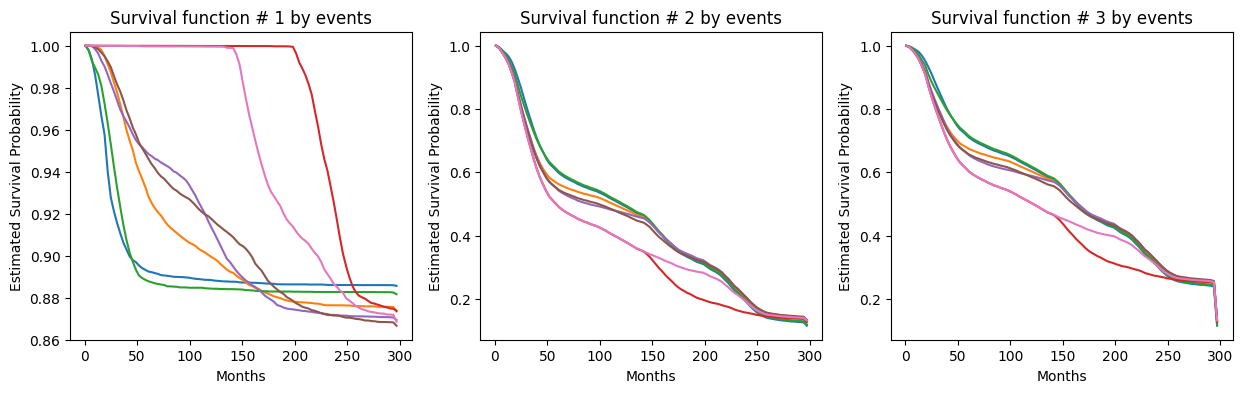

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
scores=[]
summ=np.empty(shape=model.duration_index.shape)
y_tmp = pd.DataFrame({'event': y_train_[1], 'duration': y_train_[0]})
#print('       до преобр.    после преобр.')
print('        1-cif_k      1-summ(cif_i)   1-summ(cif_i) {i=0..95}')
for i in df.event.unique():
  if i:
    # tmp = (cif.transpose()[..., i-1]).mean(axis=0)
    # summ += tmp

    # tmp = (tmp-np.min(tmp))/(np.max(tmp)-np.min(tmp))
    # cif_k = (cif.transpose()[..., i-1])
    # d = np.max(cif_k, axis=1)-np.min(cif_k, axis=1)
    # d[d==0]=1
    # cif_k = (cif_k-np.repeat(np.min(cif_k, axis=1), cif_k.shape[1]).reshape(cif_k.shape))/np.repeat(d, cif_k.shape[1]).reshape(cif_k.shape)

    sf1, grid = convert(surv_func_1(cif, i), model.duration_index, y_train['duration'].values)
    sf2, grid = convert(surv_func_2(cif, i), model.duration_index, y_train['duration'].values)
    sf3, grid = convert(surv_func_3(cif, i), model.duration_index, y_train['duration'].values)

    # ibs_ = ibs_remain(get_y_event(y_tmp, [i]),
    #                   get_y_event(y_test, [i]),
    #                   1-cif_k, times=model.duration_index, axis=-1)

    ibs_1 = ibs_remain(get_y_event(y_tmp, [i]),
                      get_y_event(y_test, [i]),
                      sf1, times=grid, axis=-1)
    ibs_2 =  ibs_remain(get_y_event(y_tmp, [i]),
                      get_y_event(y_test, [i]),
                      sf2, times=grid, axis=-1)
    ibs_3 = ibs_remain(get_y_event(y_tmp, [i]),
                      get_y_event(y_test, [i]),
                      sf3, times=grid, axis=-1)
    #scores.append(ibs_)
    print(f"ibs {i:<2}:   {ibs_1:<4.2f}         {ibs_2:<8.2f}               {ibs_3:<8.2f}")
    axs[0].plot(grid,
          sf1.mean(axis=0),
          label=f"event {i}")
    axs[1].plot(grid,
          sf2.mean(axis=0),
          label=f"event {i}")
    axs[2].plot(grid,
          sf3.mean(axis=0),
          label=f"event {i}")

est, _ = convert(cif.transpose()[..., sorted(df.event.unique()-1)[1:]].mean(axis=2),
              model.duration_index, y_train['duration'].values)

ibs_ = ibs_remain(get_y_event(y_tmp, sorted(df.event.unique())[1:]),
                  get_y_event(y_test, sorted(df.event.unique())[1:]),
                  est, grid, axis=-1)

print('---------\n', f"ibs: {ibs_:.2f}")
ibs['DeepHit']=scores
for i in (0, 1,2):
  axs[i].set_title(f"Survival function # {i+1} by events")
  axs[i].set_xlabel("Months")
  axs[i].set_ylabel("Estimated Survival Probability")

plt.show()

Здесь использовалось линейное преобразование  оси Y в [0, 1], т.к. cif_k <= 0.12 (+-) (т.к. $\sum_{k}cif_k + S(t) = 1$) (Аналогично в AalenJohansen, но там осталось 0.12)

---

ниже график S(t)

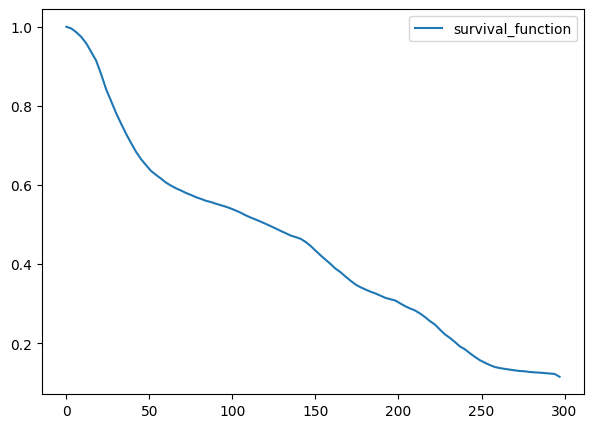

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(model.duration_index,
          1-summ,
          label=f"survival_function")
ax.legend()
plt.show()

## IBS

In [11]:
def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    """ IBS with equal impact of partial observation with controlled quantity """
    test_event, test_time = check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0

    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t,
                                      estim_before[:, i],
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                         for i, t in enumerate(times)]), axis=1)
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / time_diff
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return brier_scores
    return None

In [ ]:
#ibs_tab = pd.DataFrame(ibs, index=[f'ibs_{i}' for i in sorted(df.event.unique())[1:]]+['IBS'])
#ibs_tab